[View in Colaboratory](https://colab.research.google.com/github/sleepless-se/Abstract/blob/master/stock_filter_016.ipynb)

##Tokanaizor の作成、保存、取得を分ける


In [25]:

!apt-get install mecab
!apt-get install libmecab-dev
!apt-get install mecab-ipadic-utf8
!pip install mecab-python3

Reading package lists... Done
Building dependency tree       
Reading state information... Done
mecab is already the newest version (0.996-3.1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libmecab-dev is already the newest version (0.996-3.1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
mecab-ipadic-utf8 is already the newest version (2.7.0-20070801+main-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [0]:
import sys
import MeCab
import pickle
from keras.datasets import boston_housing
from keras.models import Model,model_from_json
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import keras
from keras.utils import to_categorical
from keras.datasets import mnist
from keras import models
from keras import layers
import time
import numpy as np
from google.colab import files
import re
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.metrics import categorical_accuracy
import pickle

def save_text_tokenizer(tokenizer,file_name):
  # saving
  with open(file_name+".pickle", 'wb') as handle:
      pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_text_tokenizer(file_name):
  # loading
  with open(file_name+".pickle", 'rb') as handle:
      return pickle.load(handle)
    
mecab = MeCab.Tagger ("-Owakati")

In [71]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/gdrive')

# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
base_dir = "/content/gdrive/My Drive/data/stock_filter/016/"
!ls "/content/gdrive/My Drive/data/stock_filter/016/"

Mounted at /content/gdrive
all_elements.json   tag_token.pickle	       tokenizer_pp_tag.pickle
alt_token.pickle    text_token.pickle	       tokenizer_p_style.pickle
href_token.pickle   tokenizer_alt.pickle       tokenizer_p_tag.pickle
iid_token.pickle    tokenizer_href.pickle      tokenizer_src.pickle
label_token.pickle  tokenizer_iid.pickle       tokenizer_style.pickle
null_label.csv	    tokenizer_label.pickle     tokenizer_tag.pickle
src_token.pickle    tokenizer_p_iid.pickle     tokenizer_text.pickle
stock_label.csv     tokenizer_pp_iid.pickle    token.pickle
style_token.pickle  tokenizer_pp_style.pickle  vari_color_label.csv


##学習データの読み込み


In [74]:
import pandas as pd

file_name = 'stock_label.csv'
stock_df = pd.read_csv(base_dir+file_name,sep=',',error_bad_lines=False,dtype={"iid": str,"style": str, "text": str})

file_name = 'varicolor_label.csv'
vari_df = pd.read_csv(base_dir+file_name,sep=',',error_bad_lines=False,dtype={"iid": str,"style": str, "text": str})

file_name = 'null_label.csv'
null_df = pd.read_csv(base_dir+file_name,sep=',',error_bad_lines=False,dtype={"iid": str,"style": str, "text": str})
null_df["label"] = "skip"
df0 = stock_df.append(vari_df, ignore_index=True)
df0 = df0.append(null_df, ignore_index=True)
df0.columns


b'Skipping line 166: expected 29 fields, saw 31\nSkipping line 873: expected 29 fields, saw 98\nSkipping line 984: expected 29 fields, saw 2539\nSkipping line 1141: expected 29 fields, saw 43\nSkipping line 1306: expected 29 fields, saw 37\nSkipping line 1720: expected 29 fields, saw 2563\nSkipping line 2169: expected 29 fields, saw 2542\nSkipping line 2552: expected 29 fields, saw 125\nSkipping line 2616: expected 29 fields, saw 34\nSkipping line 3529: expected 29 fields, saw 733\nSkipping line 4302: expected 29 fields, saw 70\nSkipping line 4327: expected 29 fields, saw 33\nSkipping line 4556: expected 29 fields, saw 81\nSkipping line 4966: expected 29 fields, saw 445\nSkipping line 5046: expected 29 fields, saw 2572\nSkipping line 5166: expected 29 fields, saw 2515\nSkipping line 5274: expected 29 fields, saw 33\nSkipping line 5827: expected 29 fields, saw 299\nSkipping line 5849: expected 29 fields, saw 37\nSkipping line 5873: expected 29 fields, saw 61\nSkipping line 5989: expecte

Index(['alt', 'disable', 'height', 'href', 'id', 'iid', 'label', 'p_height',
       'p_iid', 'p_style', 'p_tag', 'p_width', 'p_x', 'p_y', 'page_id',
       'pp_height', 'pp_iid', 'pp_style', 'pp_tag', 'pp_width', 'pp_x', 'pp_y',
       'src', 'style', 'tag', 'text', 'width', 'x', 'y'],
      dtype='object')

## 分かち書きをしたりするテキストの前処理

In [0]:

def to_df(token,se):
  matrix = token.texts_to_matrix(se,mode='count')
  temp_df = pd.DataFrame(matrix)
  return temp_df

def add_space_front_uppercase(text:str)->str:
  return ''.join(' ' + char if char.isupper() else char.strip() for char in text).strip()

def add_space_color_size(text:str)->str:
  return text.replace("color"," color ").replace("size"," size ")


def tag_filter(tag:str)->str:
  tags = ["option","li","div","span"]
  tag = tag if tag in tags else "0"
  return tag

def wakati(text)->str:
  text = str(text)
  if len(text)>3:
    text = mecab.parse(text)
  return replace_numbers_to_0(text)

def replace_numbers_to_0(text:str)->str:
  return re.sub(r'[0-9]+', "0",str(text))

def pre_text(df):
  wakachi_fileds = ['alt', 'href', 'iid','p_iid', 'p_style', 'p_tag', 'pp_iid', 'pp_style', 'pp_tag','src', 'style', 'tag', 'text']
  df[wakachi_fileds] = df[wakachi_fileds].applymap(lambda x : wakati(x)).fillna("")

  add_space_fileds = ["iid","style","p_iid","p_style","pp_iid","pp_style"]
  df[add_space_fileds] = df[add_space_fileds].applymap(lambda x : add_space_front_uppercase(x))
  df[add_space_fileds] = df[add_space_fileds].applymap(lambda x : add_space_color_size(x))
  return df                


## 学習データ全体の前処理

In [0]:

def prepare_data(data):
  df = pd.DataFrame(data)
  df = pre_text(df)

  fields = ['height', 'width', 'x', 'y',  'p_x', 'p_y', 'p_width','p_height','pp_height', 'pp_width', 'pp_x', 'pp_y']
  X = df[fields]

  X = pd.concat([X, to_df(tag_token,df["tag"])], axis=1)
  X = pd.concat([X, to_df(tag_token,df["p_tag"])], axis=1)
  X = pd.concat([X, to_df(tag_token,df["pp_tag"])], axis=1)
  X = pd.concat([X, to_df(style_token,df["style"])], axis=1)
  X = pd.concat([X, to_df(style_token,df["p_style"])], axis=1)
  X = pd.concat([X, to_df(style_token,df["pp_style"])], axis=1)
  X = pd.concat([X, to_df(iid_token,df["iid"])], axis=1)
  X = pd.concat([X, to_df(iid_token,df["p_iid"])], axis=1)
  X = pd.concat([X, to_df(iid_token,df["pp_iid"])], axis=1)
  X = pd.concat([X, to_df(alt_token,df["alt"])], axis=1)
  X = pd.concat([X, to_df(src_token,df["src"])], axis=1)
  X = pd.concat([X, to_df(href_token,df["href"])], axis=1)
  X = pd.concat([X, to_df(text_token,df["text"])], axis=1)
  X = X.fillna(0)
  return X

## tokenの作成

In [0]:
temp_df = df["tag"].append(df["p_tag"]).append(df["pp_tag"])
tag_token = Tokenizer(lower=True)
tag_token.fit_on_texts(temp_df)

temp_df = df["iid"].append(df["p_iid"]).append(df["pp_iid"])
iid_token = Tokenizer(100,lower=True)
iid_token.fit_on_texts(temp_df)

temp_df = df["style"].append(df["p_style"]).append(df["pp_style"])
style_token = Tokenizer(100,lower=True)
style_token.fit_on_texts(temp_df)

alt_token = Tokenizer(100,lower=True)
alt_token.fit_on_texts(df["alt"])
src_token = Tokenizer(100,lower=True)
src_token.fit_on_texts(df["src"])
href_token = Tokenizer(100,lower=True)
href_token.fit_on_texts(df["href"])
text_token = Tokenizer(300,lower=True)
text_token.fit_on_texts(df["text"])


##学習データを作成

In [126]:
         
df = pre_text(df0)
X = prepare_data(df)
print(X.shape)


(66634, 1350)


## ラベルを作成

In [128]:
label_token = Tokenizer()
label_token.fit_on_texts(df["label"])
save_text_tokenizer(label_token,base_dir+"label_token")
y = label_token.texts_to_matrix(df["label"])
print(y.shape)

(66634, 7)


## ラベルの変換用ディクショナリの作成

In [129]:
label_dic= {v: k for k, v in label_token.word_index.items()}
print(label_dic)

{1: 'skip', 2: 'stock', 3: 'vari', 4: 'outofstock', 5: 'color', 6: 'varicolor'}


## 学習データをシャッフル

In [0]:
seed = 7
np.random.seed(seed)
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.33, random_state=seed)

## 学習データをシャッフルしない

In [0]:
def non_shuffling_train_test_split(X, y, test_size=0.33):
    i = int((1 - test_size) * X.shape[0]) + 1
    X_train, X_test = np.split(X, [i])
    y_train, y_test = np.split(y, [i])
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test  = non_shuffling_train_test_split(X, y, test_size=0.33)

## 学習開始

Train on 44644 samples, validate on 21990 samples
Epoch 1/20
44644/44644 [==============================] - 6s 140us/step - loss: 0.1332 - categorical_accuracy: 0.8653 - val_loss: 0.0560 - val_categorical_accuracy: 0.9101
Epoch 2/20
44644/44644 [==============================] - 6s 124us/step - loss: 0.0556 - categorical_accuracy: 0.9196 - val_loss: 0.0434 - val_categorical_accuracy: 0.9276
Epoch 3/20
44644/44644 [==============================] - 6s 124us/step - loss: 0.0458 - categorical_accuracy: 0.9297 - val_loss: 0.0333 - val_categorical_accuracy: 0.9381
Epoch 4/20
44644/44644 [==============================] - 6s 124us/step - loss: 0.0387 - categorical_accuracy: 0.9382 - val_loss: 0.0342 - val_categorical_accuracy: 0.9535
Epoch 5/20
44644/44644 [==============================] - 6s 124us/step - loss: 0.0349 - categorical_accuracy: 0.9455 - val_loss: 0.0265 - val_categorical_accuracy: 0.9621
Epoch 6/20
44644/44644 [==============================] - 5s 123us/step - loss: 0.0315 - c

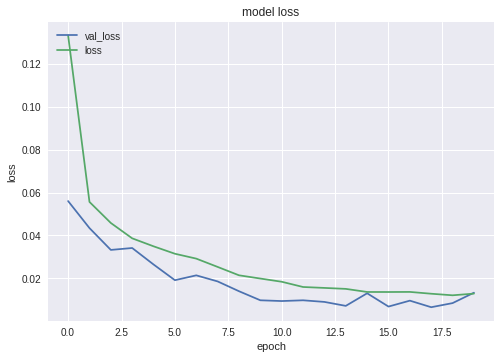

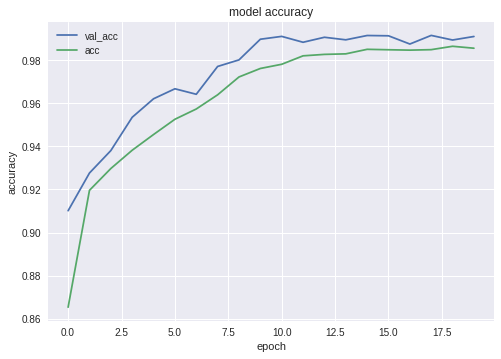

In [131]:
EPOCHS = 20
BATCH_SIZE = 275

early_stopping = EarlyStopping(monitor='val_loss', patience=3)


model = models.Sequential()
model.add(layers.Dense(1024, activation='relu',
                       input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(160, activation='relu'))
model.add(layers.Dropout(0.3))


model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))


model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(y_train.shape[1],activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['categorical_accuracy'])
history = model.fit(X_train, y_train,verbose=1, validation_data=(X_test,y_test), epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=[early_stopping])
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


import matplotlib.pyplot as plt

print(history.history.keys())
# summarize history for loss
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val_loss', 'loss'], loc='upper left')
plt.show()

plt.plot(history.history['val_categorical_accuracy'])
plt.plot(history.history['categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val_acc', 'acc'], loc='upper left')
plt.show()




```

model = models.Sequential()
model.add(layers.Dense(1024, activation='relu',
                       input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.3))


model.add(layers.Dense(160, activation='relu'))
model.add(layers.Dropout(0.3))


model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))


model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(y_train.shape[1],activation='softmax'))```



Test accuracy: 0.9949977262391997


## tokenの保存

In [0]:
save_text_tokenizer(tag_token,base_dir+"tag_token")
save_text_tokenizer(iid_token,base_dir+"iid_token")
save_text_tokenizer(style_token,base_dir+"style_token")
save_text_tokenizer(href_token,base_dir+"href_token")
save_text_tokenizer(src_token,base_dir+"src_token")
save_text_tokenizer(alt_token,base_dir+"alt_token")
save_text_tokenizer(text_token,base_dir+"text_token")

## Tokenisor を読み込む

In [0]:
tag_token = load_text_tokenizer(base_dir+"tag_token")
tag_token = load_text_tokenizer(base_dir+"tag_token")
tag_token = load_text_tokenizer(base_dir+"tag_token")
tag_token = load_text_tokenizer(base_dir+"tag_token")
tag_token = load_text_tokenizer(base_dir+"tag_token")
tag_token = load_text_tokenizer(base_dir+"tag_token")
tag_token = load_text_tokenizer(base_dir+"tag_token")
tag_token = load_text_tokenizer(base_dir+"tag_token")



## モデルと重みを保存する

In [0]:

# serialize model to JSON
model_json = model.to_json()
with open("model_015.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_015.h5")
print("Saved model to disk")

Saved model to disk


## モデルと重みを読み込む

###テストデータの予測結果を一つずつ確認。

##作成したモデルを保存する



###モデルを保存


In [0]:

# serialize model to JSON
model_json = model.to_json()
with open(base_dir + "model.json", "w") as json_file:
    json_file.write(model_json)
    
with open(base_dir + "model.h5",'w') as model_file: 
  model.save_weights(base_dir+"model.h5")

###モデルを読み込み

In [136]:
with open(base_dir+'model.json', 'r') as json_file:
  loaded_model_json = json_file.read()
  loaded_model = model_from_json(loaded_model_json)

with open(base_dir+"model.h5",'r') as model_file: 
  loaded_model.load_weights(base_dir+"model.h5")
  print("Loaded model from disk")

Loaded model from disk


###モデルの復元が正確かを確認

In [138]:
loaded_model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['categorical_accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.013336440061516349
Test accuracy: 0.9910413824465666


###モデルを使って検証

###モデルと重みをダウンロード

In [0]:
files.download("model.json")


In [0]:
files.download("model.h5")

In [0]:
con = 0
length = 200
for i in range(length):
#   print(X_test[i:i+1])
  result = model.predict(X_test[i:i+1])
  
  
  predict_result = label_dic.get(np.argmax(result))
  y_label = label_dic.get(np.argmax(y_test[i:i+1]))
  if y_label != predict_result:
#     print('con',con)
    con += 1
    print('Result:', result)
    print('predict_label:', label_dic.get(np.argmax(result)),' y_label:', label_dic.get(np.argmax(y_test[i:i+1])))
print("con", con)
print("score", con/length)